In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import random
import cmath

from scipy.stats import norm
import matplotlib.mlab as mlab

# notes on comments: Q - Questions, A - Attention (to do, to pay attention to)

np.random.seed(8)

In [2]:
# BASIC FUNCTIONS

# lif neuron with noise (Gaussian)
def LIF_step_noise(voltage, tau, current, dt, threshold, voltage_rest, resistance, std_noise):
    if voltage < threshold:
        return (- voltage + current * resistance + voltage_rest) * dt / tau + voltage + np.random.normal(0, std_noise, 1)
    else:
        return voltage_rest + np.random.normal(0, std_noise, 1)
    
# grad decent (real numbers), quadratic error function, target function: product
def weight_update(weights, x, y, mu): 
    # mu learning rate
    return weights + 2 * mu * (y - np.dot(weights, x)) * x

# grad decent (real numbers), quadratic error function, target function: sum
def delay_update_2(delays, x, y, mu): 
    # shape of delays: (neurons,)
    # mu learning rate
    return delays + 2 * mu * (y - (x + delays)) #ATTENTION: Y is a scalar, x and delays are vectors (but it works)!!!

# (complex) phase
def convert_phase(T, t):
    return math.pi * t / (T * 2) 

# time from (complex) phase
def convert_phase_back(T, phi):
    return phi * 2 * t_max / math.pi

# complex exponential for arrays
def convert_exp(array): 
    res = np.zeros(len(array), dtype=np.complex_)
    for a in range(len(array)):
        res[a] = cmath.exp(array[a])
    return res

In [3]:
# PARAMETER SETTINGS

#lif neuron
dt = 0.001
tau = 5 
threshold = -40 
voltage_rest = -70
resistance = 1
std_noise = 0.01 # std Gaussian LIF neuron noise

#data set
neurons = 10 # called N in master thesis
t_max = 10 # called T in master thesis

learning_rate = 0.1

In [4]:
# variables that store values for evaluation

collect_mean_delta_weight = []
collect_mean_delta_delay = []

collect_count = []

In [5]:
# DATA SET X (BASIC PATTERN ASSIGNED RANDOMLY)
# creates one 'basic pattern' and adds some noise on top (to get train/test data)

# A: Gaussian: long tails (overlap intervals, neg weights possible for high std), by 'chance' two spikes at the same time

def data(neurons, t_max, size, std_jitter, std_p):
    # neurons: number of neurons
    # size: size of the whole data set
    # t_max: length of one time interval
    # std_jitter / std_p: noise parameters 
    collect_delays = np.zeros((neurons, size))
    collect_weights = np.zeros((neurons, size))
    X_delays = np.random.uniform(0, t_max, neurons) # arbitrary 'spike pattern' - 'basis'
    X_weights = np.ones(neurons) # 'weight of input' (equals the probability of the neurons to 'add their spike pattern to input LIF')
    
    for a in range(size):
        jitter = np.random.normal(0, std_jitter, neurons)
        jitter_2 = np.random.normal(0, std_p, neurons)
        collect_delays[:, a] = X_delays + jitter
        collect_weights[:, a] = X_weights + jitter_2
        
    return collect_delays, collect_weights, X_delays, X_weights
    
    
# DESIRED OUTPUT O

Y_delay = 12 # desired postsyn spike time, arbitrarily set to a value greater than t_max
Y_weight = abs(threshold - voltage_rest)

In [6]:
#DATA SET X - CONVERT TO COMPLEX NUMBERS 

def data_complex(neurons, X_delays, X_weights):
    # input: the basic pattern generated by the function 'data'
    complex_X = np.zeros((neurons, 1), dtype=np.complex_) # (neurons x 1), this structure is necessary for functionality of module_1
    for a in range(neurons):
        complex_X[a, 0] = cmath.exp(complex(0, 1) * convert_phase(t_max, X_delays[a])) * X_weights[a]
    return complex_X
        
# DESIRED OUTPUT O - CONVERT TO COMPLEX NUMBERS

complex_Y = cmath.exp(complex(0, 1) * convert_phase(t_max, Y_delay)) * Y_weight

In [7]:
# MODULE 2 - GRADIENT DESCENT

# module_2: grad decent one training example
# module_2_2: grad decent with different training examples every step ('noisy'), 'mini-batch'

# Q: 'noisy': no noise on Y, learning rate changing dynamically

def module_2 (X_pattern, X_weight, Y, Y_weight, learning_rate, iterations, neurons):
    d_evolution = np.zeros((neurons, iterations, 2))
    for a in range(iterations):
        if a > 0:
            #learning rate needs to be adapted to number of neurons (for weights), otherwise no convergence (e.g. oscillations for too high rates)
            d_evolution[:, a, 0] = delay_update_2(d_evolution[:, a - 1, 0], X_pattern, Y, learning_rate)
            d_evolution[:, a, 1] = weight_update(d_evolution[:, a - 1, 1], X_weight, Y_weight, learning_rate / neurons)
    return d_evolution

def module_2_2 (X_pattern, X_weight, Y, Y_weight, learning_rate, iterations, neurons):
    d_evolution = np.zeros((neurons, iterations + 1, 2))
    for a in range(iterations + 1):
        if a > 0:
            d_evolution[:, a, 0] = delay_update_2(d_evolution[:, a - 1, 0], X_pattern[:, a], Y, learning_rate)
            d_evolution[:, a, 1] = weight_update(d_evolution[:, a - 1, 1], X_weight[:, a], Y_weight, learning_rate / neurons)
    return d_evolution

/home/laura/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


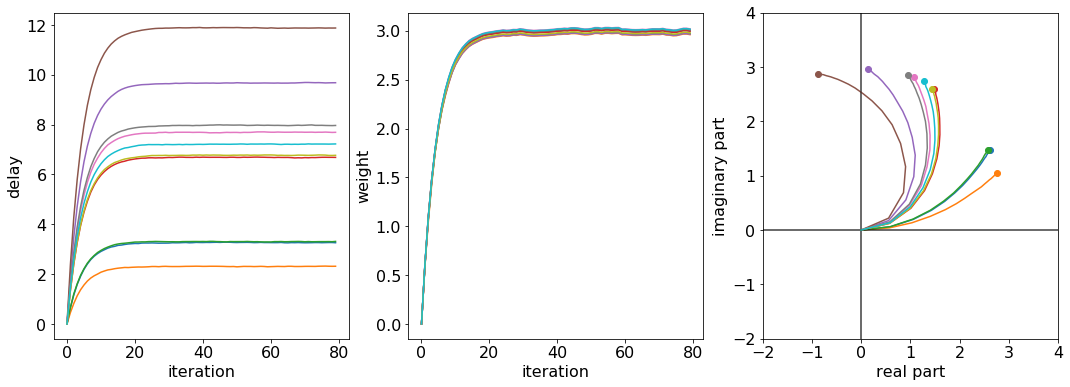

In [8]:
# TEST MODULE 2 AND VISUALIZE OUTPUT

plt.figure(figsize = (18,6))
plt.rcParams.update({'font.size': 16}) # change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

size_dataset_1 = 100
training = 0.8
iterations = int(size_dataset_1 * training) - 1

delays, weights, basic_delay, basic_weight = data(neurons, t_max, size_dataset_1, 0.025, 0.025)
result = module_2_2(delays, weights, Y_delay, Y_weight, learning_rate, iterations, neurons)
    
for b in range(neurons):
    # delays
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(iterations + 1), result[b, :, 0])
    plt.xlabel('iteration')
    plt.ylabel('delay')

    # weights
    plt.subplot(1, 3, 2)
    plt.plot(np.arange(iterations + 1), result[b, :, 1])
    plt.xlabel('iteration')
    plt.ylabel('weight')
    
    res = result[b, :, 1] * convert_exp(complex(0, 1) * convert_phase(t_max, result[b, :, 0]))
    ax = plt.subplot(1, 3, 3)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(res.real, res.imag, color=color)
    plt.plot(res[iterations].real, res[iterations].imag, 'o', color=color)
    lim = (Y_weight + 10) / neurons
    plt.xlim(-lim * 0.5, lim)
    plt.ylim(-lim * 0.5, lim)
    plt.axvline(0, color = 'k', alpha = 0.1)        
    plt.axhline(0, color = 'k', alpha = 0.1)
    plt.xlabel('real part')
    plt.ylabel('imaginary part')

#plt.savefig('module_2.pdf')
plt.show()

In [9]:
# MODULE 1 - LINEAR ALGEBRA (on complex data)

def module_1 (complex_pattern, complex_Y):
    return np.linalg.pinv((complex_pattern))  * (complex_Y)

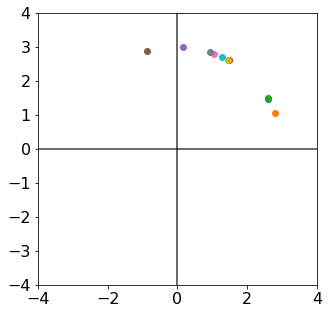

In [10]:
# TEST MODULE 1 AND VISUALIZE OUTPUT

plt.figure(figsize = (5,5))

complex_pattern = data_complex(neurons, basic_delay, basic_weight)
result_2 = module_1(complex_pattern, complex_Y)

for a in range(neurons):
    plt.plot(result_2[0, a].real, result_2[0, a].imag, 'o')
    lim = (Y_weight + 10) / neurons
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axvline(0, color = 'k', alpha = 0.1)        
    plt.axhline(0, color = 'k', alpha = 0.1)

In [11]:
# MEAN DISTANCE BETWEEN RESULTS (weights) MODULE 1/2 (real space)

# (result module 1 - result module 2) / result module 2

delta_delay = []
delta_weight = []

for i in range(neurons):
    delta_delay.append(abs(convert_phase_back(t_max, cmath.phase(result_2[0, i])) - result[i, iterations, 0]) / result[i, iterations, 0])
    delta_weight.append(abs(abs(result_2[0, i]) - result[i, iterations, 1]) / result[i, iterations, 1])
    
mean_delta_delay = np.mean(delta_delay)
mean_delta_weight = np.mean(delta_weight)

print('mean distance delay normalized over delay module 2: %.3E' % (mean_delta_delay))
print('mean distance weight normalized over weight module 2: %.3E' % (mean_delta_weight))

collect_mean_delta_delay.append(mean_delta_delay)
collect_mean_delta_weight.append(mean_delta_weight)

mean distance delay normalized over delay module 2: 1.005E-03
mean distance weight normalized over weight module 2: 6.228E-03


/home/laura/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


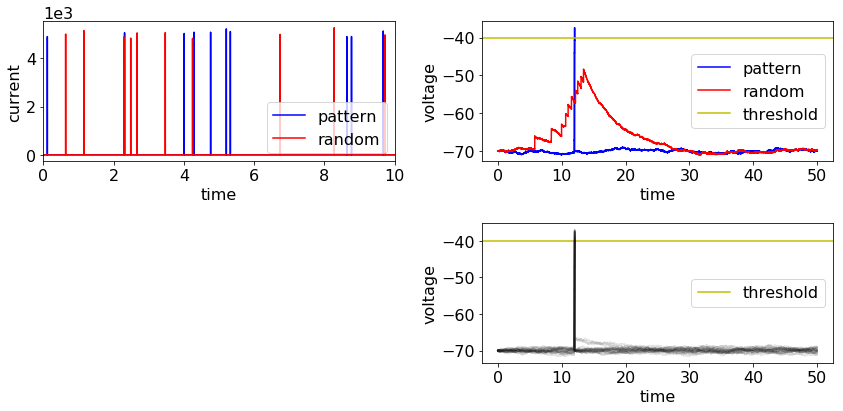

In [12]:
# INPUT CURRENT PRE/POST AND MEMBRANE VOLTAGE LIF NEURON FOR PATTERN/RANDOM INPUT 

# A: decay parameter = t_max (now) / 2 (independence assumption)
# A: noise on membrane potential 

# Q: time resolution of the simulation
# Q: scaling of the weights (to compensate noise e.g.)

plt.figure(figsize = (12, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

time_max = 50 #max time of the simulation

count = 0

for l in range(20 + 1):
    if l < 20: 
        X = delays[:, (iterations + l)] 
        X_w = weights[:, (iterations + l)] 
    else: 
        # arbitrary spike pattern 
        X = np.random.uniform(0, t_max, neurons) 
        jitter_2 = np.random.normal(0, 0.025, neurons)
        X_w = np.ones(neurons) + jitter_2 

    # membrane voltage postsyn
    voltage_steps = np.zeros((int(time_max/dt), 1))

    # input current post (determined by spikes and respective delays) 
    spikes_ = np.zeros(int(time_max / dt)) 

    # input current pre (determined by spikes)
    spikes_2 = np.zeros(int(time_max / dt)) 

    # times of spikes postsyn, using result grad decent mini-batch
    times = X + result[:, iterations, 0]
    times_sorted = np.sort(times)

    # round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
    # necessary to clearly define the input current
    # times_rounded - postsyn spike times
    # times_rounded_2 - presyn spike times
    times_rounded = np.round_(times_sorted, decimals = 3) 
    times_rounded_2 = np.round_(X, decimals = 3) 

    # weights, using result grad decent mini-batch
    # scaled by a constant factor to make the algorithm stable against noise
    weights_ = result[:, iterations, 1] * 1.1

    # postsyn spike train (input current post)
    for a in range(neurons):
        if spikes_[int(times_rounded[a] / dt)] == 0: 
            spikes_[int(times_rounded[a] / dt)] = weights_[a] * tau / dt * X_w[a]
        else: 
            spikes_[int(times_rounded[a] / dt)] = spikes_[int(times_rounded[a] / dt)] + weights_[a] * tau / dt * X_w[a]
    # presyn spike train (input current pre)
        spikes_2[int(times_rounded_2[a] / dt)] = tau / dt * X_w[a]

    # membrane potential   
    for k in range(int(time_max / dt)):
        if k ==0:
            voltage_steps[k, 0] = voltage_rest
        if k > 0:
            voltage_steps[k, 0] = LIF_step_noise(voltage_steps[k - 1, 0], tau, spikes_[k], dt, threshold, voltage_rest, resistance, std_noise)
        if voltage_steps[k, 0] > threshold: 
            #print(' test example %.0f over threshold with membrane potential of %.2f' % (l, voltage_steps[k, 0]))
            count = count + 1
            
    # plotting results ----------------------
        
    if l == 0:
        # presyn spike train of one test example
        plt.subplot(2, 2, 1)
        plt.plot(np.arange(int(time_max/dt)) * dt, spikes_2, color = 'b', label = 'pattern')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        plt.xlabel('time')
        plt.ylabel('current')
        plt.xlim(0, 10)

        # postsyn spike trains (input current pattern)
        #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        #plt.plot(np.arange(int(time_max/dt)) * dt, spikes_, color = 'b')
        #plt.xlabel('time')
        #plt.ylabel('current')

        # membrane voltage of one test example
        plt.subplot(2, 2, 2)
        plt.plot(np.arange(int(time_max/dt)) * dt, voltage_steps[:, 0], color = 'b', alpha = 1, label = 'pattern')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('voltage')
        
    # membrane voltage all test examples
    if l < 20:
        plt.subplot(2, 2, 4)
        plt.plot(np.arange(int(time_max/dt)) * dt, voltage_steps[:, 0], color = 'k', alpha = 0.1)
    if l == 0:
        plt.subplot(2, 2,4)
        plt.axhline(threshold, color= 'y', label = 'threshold')
        plt.xlabel('time')
        plt.ylabel('voltage')
        plt.legend()

    if l == 20:
        # presyn spike train of one random example
        plt.subplot(2, 2, 1)
        plt.plot(np.arange(int(time_max/dt)) * dt, spikes_2, color = 'r', label = 'random')
        plt.xlim(0, 10)
        plt.legend(loc = 4)
        
        # postsyn spike train
        #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        #plt.plot(np.arange(int(time_max/dt)) * dt, spikes_, color = 'r')
        #plt.xlabel('time')
        #plt.ylabel('current')

        # membrane voltage of one random example
        plt.subplot(2, 2, 2)
        plt.plot(np.arange(int(time_max/dt)) * dt, voltage_steps[:, 0], color = 'r', alpha = 1, label = 'random')
        plt.axhline(threshold, color = 'y', label = 'threshold')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('voltage')

plt.tight_layout()
#plt.savefig('currents_and_potential.pdf')
plt.show()

collect_count.append(count)

In [13]:
# same calculations for 9 more data sets

size_dataset_1 = 100
training = 0.8
iterations = int(size_dataset_1 * training) - 1

for zae in range(9):

    delays, weights, basic_delay, basic_weight = data(neurons, t_max, size_dataset_1, 0.025, 0.025)
    result = module_2_2(delays, weights, Y_delay, Y_weight, learning_rate, iterations, neurons)

    complex_pattern = data_complex(neurons, basic_delay, basic_weight)
    result_2 = module_1(complex_pattern, complex_Y)

    delta_delay = []
    delta_weight = []

    for i in range(neurons):
        delta_delay.append(abs(convert_phase_back(t_max, cmath.phase(result_2[0, i])) - result[i, iterations, 0]) / result[i, iterations, 0])
        delta_weight.append(abs(abs(result_2[0, i]) - result[i, iterations, 1]) / result[i, iterations, 1])

    mean_delta_delay = np.mean(delta_delay)
    mean_delta_weight = np.mean(delta_weight)
    
    collect_mean_delta_delay.append(mean_delta_delay)
    collect_mean_delta_weight.append(mean_delta_weight)

    count = 0

    for l in range(20):
        if l < 20: 
            # pick one test example arbitrary (basic pattern + noise)
            X = delays[:, (iterations + l)] 
            X_w = weights[:, (iterations + l)] 
      
        # membrane voltage postsyn
        voltage_steps = np.zeros((int(time_max/dt), 1))

        # input current (determined by spikes and respective delays) - postsyn.
        spikes_ = np.zeros(int(time_max / dt)) 

        # input current (determined by spikes) - presyn.
        spikes_2 = np.zeros(int(time_max / dt)) 

        # times of spikes postsyn, using result grad decent mini-batch
        times = X + result[:, iterations, 0]
        times_sorted = np.sort(times)

        # round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
        # necessary to clearly define the input current
        # times_rounded - postsyn spike times
        # times_rounded_2 - presyn spike times
        times_rounded = np.round_(times_sorted, decimals = 3) 
        times_rounded_2 = np.round_(X, decimals = 3) 

        # weights, using result grad decent mini-batch
        # scaled by a constant factor to make the algorithm stable against noise
        weights_ = result[:, iterations, 1] * 1.1

        # postsyn spike train (input current post)
        for a in range(neurons):
            if spikes_[int(times_rounded[a] / dt)] == 0: 
                spikes_[int(times_rounded[a] / dt)] = weights_[a] * tau / dt * X_w[a]
            else: 
                spikes_[int(times_rounded[a] / dt)] = spikes_[int(times_rounded[a] / dt)] + weights_[a] * tau / dt * X_w[a]
        # presyn spike train
            spikes_2[int(times_rounded_2[a] / dt)] = tau / dt * X_w[a]

        # membrane potential   
        for k in range(int(time_max / dt)):
            if k ==0:
                voltage_steps[k, 0] = voltage_rest
            if k > 0:
                voltage_steps[k, 0] = LIF_step_noise(voltage_steps[k - 1, 0], tau, spikes_[k], dt, threshold, voltage_rest, resistance, std_noise)
            if voltage_steps[k, 0] > threshold: 
                count = count + 1
                
    collect_count.append(count)

In [14]:
print(np.mean(collect_count))
print(np.std(collect_count))
print(np.mean(collect_mean_delta_delay))
print(np.std(collect_mean_delta_delay))
print(np.mean(collect_mean_delta_weight))
print(np.std(collect_mean_delta_weight))

20.0
0.0
0.0011160536696468975
0.00035394020728411995
0.007039657257735444
0.0012686012657586777
